# Proyecto 3.B. Parte 3. Diseño de DSS en Empresa de Ventas en la Red: Stacking

Vamos a intentar crear un modelo más preciso mediante *stacking*.

In [1]:
!pip install bayesian-optimization
!pip install lightgbm
!pip install xgboost

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11686 sha256=25b36c74f603947c7360cd69ca70c458e3fb665cb9b7d92712c08c8d8d1cf240
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [2]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

import pickle

# %matplotlib inline
plt.style.use('ggplot')
# Elimina la limitación en visualización del numero de columnas
pd.set_option('display.max_columns', None) 

## Cargamos la Base de Datos

In [3]:
!wget https://github.com/IC1920/Datasets/raw/master/train.zip -O train.zip
!wget https://github.com/IC1920/Datasets/raw/master/test.zip -O test.zip
!unzip -o train.zip
!unzip -o test.zip

--2021-06-12 15:40:30--  https://github.com/IC1920/Datasets/raw/master/train.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip [following]
--2021-06-12 15:40:30--  https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1655239 (1.6M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   1.58M  --.-KB/s    in 0.05s   

2021-06-12 15:40:30 (29.8 MB/s) - ‘train.zip’ saved [1655239/1655239]

--2021-06-12 15:40:31--  https://github.com/IC1920/Datasets/raw/master/test.zip

In [4]:
# Leemos los archivos arff
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

features = ['feat_'+str(i) for i in np.arange(1,94)]
target = 'target'

(61878, 95) (144368, 94)


## Preprocesado de la Base de Datos

Aunque a los árboles no les suele afectar en demasía que las variables tengan diferentes rangos, vamos a tipificar los datos con *Z-Score* para si vamos a usar otros algoritmos supervisados, como KNN, o no supervisados, como clústering.

In [5]:
scaler = StandardScaler()
scaler.fit(df_train[features].values)
X_train_scaled = scaler.transform(df_train[features].values)
X_test_scaled = scaler.transform(df_test[features].values)

Preparamos las bases de datos. Para poder hacer una validación local, extraemos un 20% de forma aleatoria de forma estratificada.

In [6]:
X_orig = X_train_scaled.copy()
y_orig = df_train[target].values.reshape(-1)
y_orig = LabelEncoder().fit_transform(y_orig)

X_train, X_val, y_train, y_val = train_test_split(X_orig, y_orig, test_size=0.20,
                                                  random_state=36, stratify=y_orig)

print("Verificamos que la partición es estratificada")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_val)/len(y_val),3))

Verificamos que la partición es estratificada
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]


## Creación del Modelo de Stacking

In [13]:
# Función que obtiene el LogLoss con repetición y para la base de datos de testeo
def entrena_model_folds(model, num_folds=5, num_bags=1, calibra=True, random_seed=2020):
    np.random.seed(random_seed)
    X_tot = X_orig.copy()
    y_tot = y_orig.copy()
    X_test = X_test_scaled.copy()
    
    # Creamos arrays para las predicciones
    preds_val = np.empty((len(X_tot), 9, num_bags))
    preds_val[:] = np.nan
    preds_test = np.empty((len(X_test), 9, num_bags*num_folds))
    preds_test[:] = np.nan
    
    # Entrena y extrae la predicciones con validación cruzada repetida
    folds = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=num_bags, random_state=random_seed)  
    for niter, (train_index, val_index) in enumerate(folds.split(X_tot, y_tot)):
        print('ITER=',niter)
        nbag = niter//num_folds #Extrae el número de repetición (bag)
        X_train, X_val = X_tot[train_index], X_tot[val_index]
        y_train, y_val = y_tot[train_index], y_tot[val_index]
        if calibra:
            calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
            calibrated_clf.fit(X_train, y_train)
            preds_val[val_index,:,nbag] = calibrated_clf.predict_proba(X_val) 
            preds_test[:,:,niter] = calibrated_clf.predict_proba(X_test)
        else:
            model.fit(X_train, y_train)
            preds_val[val_index,:,nbag] = model.predict_proba(X_val) 
            preds_test[:,:,niter] = model.predict_proba(X_test)
        
    # Promedia las predicciones
    preds_val_mean = preds_val.mean(axis=2) 
    preds_test_mean = preds_test.mean(axis=2)

    # Extrae las métricas
    log_loss_val = log_loss(y_tot, preds_val_mean, eps=1e-15, normalize=True)
    return log_loss_val, y_tot, preds_val_mean, preds_test_mean

## Creamos la Base de Datos de Nivel 0

**ATENCION: El coste computacional del calculo de la BD de nivel 0 es alto. NO EJECUTAR EL CALCULO SI NO SE DISPONE DE UN EQUIPO LOCAL DE ALTAS PRESTACIONES.**


El profesor ya ha calculado y dejado en un repositorio la base de datos con las features calculadas (ver punto 1.5).

In [ ]:
CALCULA_BD0 = False

In [ ]:
if CALCULA_BD0:
    # Inicializamos listas 
    loss_list = []
    y_val_list = []
    preds_val_list = []
    preds_tst_list = []
    names_col = []

In [ ]:
def saca_features(modelo, calibra=True):
    loss, y_val, preds_val, preds_test  = entrena_model_folds(modelo, calibra=calibra)
    print(f'Loss con 5CV={loss}')
    return loss, y_val, preds_val, preds_test    

### Modelo Random Forest (RF)

In [ ]:
%%time
if CALCULA_BD0:
    # Modelo Random Forest
    modelo = RandomForestClassifier(n_estimators=600,
                                      max_features=9,
                                      min_samples_split=2,
                                      n_jobs=-1,class_weight='balanced')
    loss, y_val, preds_val, preds_test = saca_features(modelo, calibra=True)

    loss_list.append(loss)
    y_val_list.append(y_val)
    preds_val_list.append(preds_val)
    preds_tst_list.append(preds_test)
    names_col.append('RF')

ITER= 0
ITER= 1
ITER= 2
ITER= 3
ITER= 4
Loss con 5CV=0.4813305167410231
CPU times: user 1h 22s, sys: 1min 27s, total: 1h 1min 49s
Wall time: 3min 44s


### Modelo Logistic Regression (LOGIT)

In [ ]:
%%time
if CALCULA_BD0:
    # Modelo Logit
    modelo = LogisticRegression(C=2.0,max_iter=450,n_jobs=-1,class_weight=None,random_state=42)
    loss, y_val, preds_val, preds_test = saca_features(modelo, calibra=False)
    loss_list.append(loss)
    y_val_list.append(y_val)
    preds_val_list.append(preds_val)
    preds_tst_list.append(preds_test)
    names_col.append('LOGIT')

ITER= 0
ITER= 1
ITER= 2
ITER= 3
ITER= 4
Loss con 5CV=0.640084912071749
CPU times: user 21.8 s, sys: 4.92 s, total: 26.7 s
Wall time: 2min 56s


### Modelo MultiLayerPerceptron (MLP)

Buscamos con Bayesian Optimizacion (BO) la mejor ANN.

In [ ]:
# Para la optimización hay que esperar bastante
OPTIMIZA = False 

if OPTIMIZA:
    from bayes_opt import BayesianOptimization

    def entrena_model_con_preds(model, calibra=True):
        np.random.seed(2020)
        if calibra:
            calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
            calibrated_clf.fit(X_train, y_train)
            preds_val = calibrated_clf.predict_proba(X_val)
            preds_tst = calibrated_clf.predict_proba(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            preds_val = model.predict_proba(X_val)
            preds_tst = model.predict_proba(X_test_scaled)
        # Extrae las métricas
        log_loss_val = log_loss(y_val, preds_val, eps=1e-15, normalize=True)
        return log_loss_val, y_val, preds_val, preds_tst

    def bo_eval(sizeh, pow_alpha):
        modelo = MLPClassifier(hidden_layer_sizes=(int(sizeh),),solver='lbfgs',activation='logistic',
                          alpha=10.0**pow_alpha,max_iter=3000,random_state=42)
        log_loss_val, _, _, _ = entrena_model_con_preds(modelo, calibra=True)
        return -log_loss_val

    # Buscamos mejor XGB
    range_bo = {'sizeh': (20, 100),  #Máxima profundidad de cada  arbol
                'pow_alpha': (-2,3), # alpha=10**pow_alpha
                }

    BO_ANN= BayesianOptimization(bo_eval, range_bo, random_state=2020)
    BO_ANN.maximize(init_points=6, n_iter=20)    
    print('MEJOR ANN=',BO_ANN.max)

In [ ]:
%%time
if CALCULA_BD0:
    # Modelo MLP
    pow_alpha = 0.5487276248579076
    sizeh = 41
    modelo = MLPClassifier(hidden_layer_sizes=(int(sizeh),),solver='lbfgs',activation='logistic',
                          alpha=10.0**pow_alpha,max_iter=5000,random_state=42)
    loss, y_val, preds_val, preds_test = saca_features(modelo, calibra=True)
    loss_list.append(loss)
    y_val_list.append(y_val)
    preds_val_list.append(preds_val)
    preds_tst_list.append(preds_test)
    names_col.append('MLP')

ITER= 0
ITER= 1
ITER= 2
ITER= 3
ITER= 4
Loss con 5CV=0.5116915253721167
CPU times: user 9h 59min 51s, sys: 35min 38s, total: 10h 35min 30s
Wall time: 31min 46s


### Modelo XGB

In [ ]:
%%time
if CALCULA_BD0:
    modelo = XGBClassifier(learning_rate =0.1, n_estimators=650, max_depth=8, 
                              subsample=0.8, colsample_bytree=0.6, nthread=20,
                              reg_alpha=0.001, reg_lambda=1.0,
                              seed=42, objective='multi:softprob')
    loss, y_val, preds_val, preds_test = saca_features(modelo, calibra=True)
    loss_list.append(loss)
    y_val_list.append(y_val)
    preds_val_list.append(preds_val)
    preds_tst_list.append(preds_test)
    names_col.append('XGB')

ITER= 0
ITER= 1
ITER= 2
ITER= 3
ITER= 4
Loss con 5CV=0.45115528144663847
CPU times: user 11h 11min 12s, sys: 10min 4s, total: 11h 21min 16s
Wall time: 34min 4s


### Creamos las Bases de Datos con las Predicciones

Creamos la Nueva Base de Datos de Entrenamiento y Testeo con las predicciones de los modelos RF, LOGIT, MLP y XGB.

In [ ]:
if CALCULA_BD0:
    names_df = []
    for namecol in names_col:
        for nclass in range(9):
            names_df.append(namecol+'_c'+str(nclass+1))
    print(names_df)    

['RF_c1', 'RF_c2', 'RF_c3', 'RF_c4', 'RF_c5', 'RF_c6', 'RF_c7', 'RF_c8', 'RF_c9', 'LOGIT_c1', 'LOGIT_c2', 'LOGIT_c3', 'LOGIT_c4', 'LOGIT_c5', 'LOGIT_c6', 'LOGIT_c7', 'LOGIT_c8', 'LOGIT_c9', 'MLP_c1', 'MLP_c2', 'MLP_c3', 'MLP_c4', 'MLP_c5', 'MLP_c6', 'MLP_c7', 'MLP_c8', 'MLP_c9', 'XGB_c1', 'XGB_c2', 'XGB_c3', 'XGB_c4', 'XGB_c5', 'XGB_c6', 'XGB_c7', 'XGB_c8', 'XGB_c9']


In [ ]:
if CALCULA_BD0:
    df_train_stack = pd.DataFrame(np.concatenate(preds_val_list,axis=1),columns=names_df)
    df_train_stack.insert(loc=df_train_stack.shape[1],column='target',value=y_val_list[0])
    df_test_stack = pd.DataFrame(np.concatenate(preds_tst_list,axis=1),columns=names_df)
    print(df_train_stack.head(3))
    
    file = open('bd_stacking.pickle','wb')
    pickle.dump(df_train_stack, file, protocol=4)
    pickle.dump(df_test_stack, file, protocol=4)
    file.close()

,RF_c1,RF_c2,RF_c3,RF_c4,RF_c5,RF_c6,RF_c7,RF_c8,RF_c9,LOGIT_c1,LOGIT_c2,LOGIT_c3,LOGIT_c4,LOGIT_c5,LOGIT_c6,LOGIT_c7,LOGIT_c8,LOGIT_c9,MLP_c1,MLP_c2,MLP_c3,MLP_c4,MLP_c5,MLP_c6,MLP_c7,MLP_c8,MLP_c9,XGB_c1,XGB_c2,XGB_c3,XGB_c4,XGB_c5,XGB_c6,XGB_c7,XGB_c8,XGB_c9,target
0,0.004751,0.000000,0.000000,0.000609,0.000024,0.991835,0.001017,0.000874,0.000891,0.000421,1.025263e-09,4.243281e-13,0.000026,8.122726e-15,0.998152,0.001157,0.000091,0.000152,0.031715,0.000227,0.000000,0.002091,0.000000,0.922184,0.017573,0.010036,0.016174,0.045687,0.000000,0.000000,0.000571,0.000000,0.947854,0.002085,0.001720,0.002084,0
1,0.160114,0.000871,0.000455,0.001055,0.001351,0.035908,0.017885,0.779444,0.002918,0.155829,8.521797e-02,2.530527e-02,0.007771,1.007624e-02,0.083105,0.063142,0.461452,0.108102,0.244329,0.023963,0.015216,0.002332,0.013851,0.041966,0.054434,0.575938,0.027971,0.075139,0.009410,0.002422,0.003268,0.000299,0.026141,0.024903,0.852626,0.005792,0
2,0.806111,0.001601,0.000392,0.000406,0.000422,0.009368,0.010009,0.006153,0.165538,0.355184,7.777332e-02,1.823750e-02,0.002059,3.613955e-03,0.107482,0.095841,0.152352,0.187457,0.664746,0.022006,0.000704,0.001457,0.001558,0.067723,0.079943,0.071899,0.089963,0.870528,0.005653,0.000966,0.000531,0.000188,0.011265,0.034664,0.013272,0.062932,0


## Leemos la base de datos para el *stacking*

In [8]:
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking.zip -O bd_stacking.zip
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking.z01 -O bd_stacking.z01
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking.z02 -O bd_stacking.z02

!7z x bd_stacking.zip -y

--2021-06-12 15:43:30--  https://github.com/IC1920/Datasets/raw/master/bd_stacking.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/bd_stacking.zip [following]
--2021-06-12 15:43:30--  https://raw.githubusercontent.com/IC1920/Datasets/master/bd_stacking.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962309 (940K) [application/zip]
Saving to: ‘bd_stacking.zip’

bd_stacking.zip     100%[===================>] 939.75K  --.-KB/s    in 0.03s   

2021-06-12 15:43:31 (26.7 MB/s) - ‘bd_stacking.zip’ saved [962309/962309]

--2021-06-12 15:43:31--  https://github.com/IC1920/D

In [ ]:
# Cargamos la Base de Datos Previa de Stacking
if False:
    file = open('bd_stacking.pickle','wb')
    pickle.dump(df_train_stack, file, protocol=4)
    pickle.dump(df_test_stack, file, protocol=4)
    file.close()
else:
    file = open('bd_stacking.pickle','rb')
    df_train_stack = pickle.load(file)
    df_test_stack = pickle.load(file)
    file.close()   

df_train_stack.head()

In [ ]:
names_df = df_test_stack.columns
scaler = StandardScaler()
X_train = df_train_stack[names_df].values.copy()
X_test = df_test_stack[names_df].values.copy()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X = X_train_scaled
y = df_train_stack['target'].values.reshape(-1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=36, stratify=y)

print("Verificamos que la partición es estratificada")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_val)/len(y_val),3))

Verificamos que la partición es estratificada
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]


### Buscamos un Modelo Stacking con XGBoost

In [ ]:
def entrena_model_hold_out(model, calibra=True, random_seed=1234):
    np.random.seed(random_seed)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds_val = calibrated_clf.predict_proba(X_val)
    else:
        model.fit(X_train, y_train)
        preds_val = model.predict_proba(X_val)

    # Extrae las métricas
    log_loss_val = log_loss(y_val, preds_val, eps=1e-15, normalize=True)
    return log_loss_val

In [ ]:
def busca_param(valores, nombre_var, parametros, random_seed=1234, cv=5):
    scores = []
    for valor in tqdm(valores):
        parametros[nombre_var]=valor
        xgb_model = XGBClassifier(learning_rate=parametros['learning_rate'],
                                  n_estimators=parametros['n_estimators'],
                                  max_depth=parametros['max_depth'],
                                  subsample=parametros['subsample'],
                                  colsample_bytree=parametros['colsample_bytree'],
                                  reg_alpha=parametros['reg_alpha'], 
                                  reg_lambda=parametros['reg_lambda'],
                                  nthread=20, 
                                  seed=random_seed, objective='multi:softprob')
        log_loss_val = entrena_model_hold_out(xgb_model, calibra=True, random_seed=random_seed)
        print(f'{nombre_var}={valor} log_loss_val={log_loss_val}')
        scores.append(log_loss_val)
    plt.plot(valores,scores,'o-')
    plt.ylabel('log_loss_val')
    plt.xlabel(nombre_var)
    print(f'Mejor {nombre_var}={valores[np.argmin(scores)]} Score={np.min(scores)}')
    return valores[np.argmin(scores)]

In [ ]:
# Parametros que vienen por defecto
parametros = {'learning_rate':0.1, 'n_estimators':100, 'max_depth':6,
              'subsample':0.80, 'colsample_bytree':0.80,
              'reg_alpha':0.0, 'reg_lambda':1.0}

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


n_estimators=25 log_loss_val=0.44322755175284495
n_estimators=50 log_loss_val=0.43460627213999453
n_estimators=75 log_loss_val=0.43325347614051674
n_estimators=100 log_loss_val=0.43048455622989484
n_estimators=125 log_loss_val=0.43089195985433854
n_estimators=150 log_loss_val=0.4337434538200728
n_estimators=175 log_loss_val=0.4345312148724422
n_estimators=200 log_loss_val=0.4350232825834591
n_estimators=225 log_loss_val=0.43540757463223295

Mejor n_estimators=100 Score=0.43048455622989484
{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


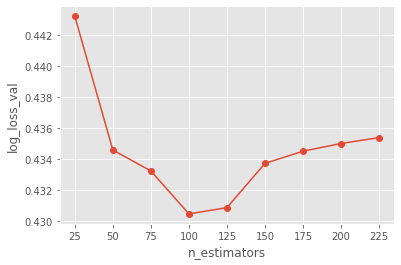

In [ ]:
# Busqueda del numero de arboles
parametros['n_estimators'] = busca_param(np.arange(25,250,25), 'n_estimators', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


max_depth=2 log_loss_val=0.4346474301310047
max_depth=3 log_loss_val=0.4320658549673581
max_depth=4 log_loss_val=0.43019108832933023
max_depth=5 log_loss_val=0.43013653364692694
max_depth=6 log_loss_val=0.43048455622989484
max_depth=7 log_loss_val=0.4327312217003977
max_depth=8 log_loss_val=0.4337634396655995
max_depth=9 log_loss_val=0.43075885655295887
max_depth=10 log_loss_val=0.43235789096571825
max_depth=11 log_loss_val=0.4333187129724154
max_depth=12 log_loss_val=0.4370970806087294
max_depth=13 log_loss_val=0.4352002193049646
max_depth=14 log_loss_val=0.4365420838447855

Mejor max_depth=5 Score=0.43013653364692694
{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


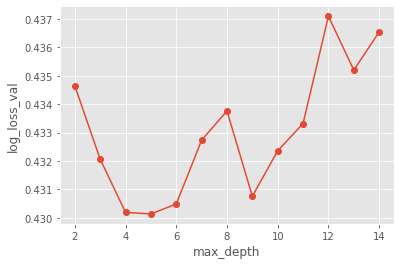

In [ ]:
parametros['max_depth'] = busca_param(np.arange(2,15), 'max_depth', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


subsample=0.1 log_loss_val=0.4373262296309462
subsample=0.2 log_loss_val=0.43290081571299843
subsample=0.3 log_loss_val=0.43022725999552053
subsample=0.4 log_loss_val=0.4306362745956511
subsample=0.5 log_loss_val=0.4299679604694633
subsample=0.6 log_loss_val=0.4340925626011205
subsample=0.7 log_loss_val=0.4324901300074931
subsample=0.8 log_loss_val=0.43013653364692694
subsample=0.9 log_loss_val=0.43091983852237764
subsample=1.0 log_loss_val=0.43110958915045455

Mejor subsample=0.5 Score=0.4299679604694633
{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


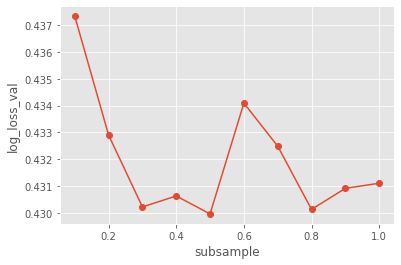

In [ ]:
parametros['subsample'] = busca_param(np.arange(1,11)/10.0, 'subsample', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


colsample_bytree=0.1 log_loss_val=0.46264012501961466
colsample_bytree=0.2 log_loss_val=0.4426270846419156
colsample_bytree=0.3 log_loss_val=0.43416928582899084
colsample_bytree=0.4 log_loss_val=0.43457546046734163
colsample_bytree=0.5 log_loss_val=0.4335375537127718
colsample_bytree=0.6 log_loss_val=0.4325969277279678
colsample_bytree=0.7 log_loss_val=0.43292973186205785
colsample_bytree=0.8 log_loss_val=0.4299679604694633
colsample_bytree=0.9 log_loss_val=0.4326978903185411
colsample_bytree=1.0 log_loss_val=0.43194738447747455

Mejor colsample_bytree=0.8 Score=0.4299679604694633
{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


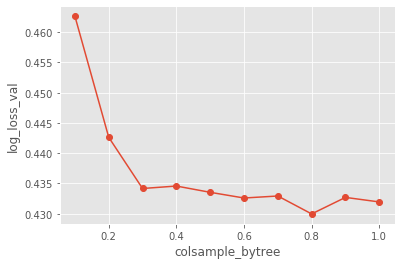

In [ ]:
parametros['colsample_bytree'] = busca_param(np.arange(1,11)/10.0, 'colsample_bytree', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


reg_alpha=0.0 log_loss_val=0.4299679604694633
reg_alpha=0.0001 log_loss_val=0.43203846087304937
reg_alpha=0.001 log_loss_val=0.4323115096774176
reg_alpha=0.01 log_loss_val=0.4321684411356485
reg_alpha=0.1 log_loss_val=0.43036929593074247
reg_alpha=1.0 log_loss_val=0.4305648931610144
reg_alpha=10 log_loss_val=0.4352349503837678

Mejor reg_alpha=0.0 Score=0.4299679604694633
{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


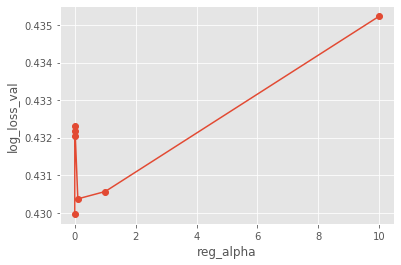

In [ ]:
# Probamos con Regularización L1
parametros['reg_alpha'] = busca_param([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10], 'reg_alpha', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


reg_lambda=0.0 log_loss_val=0.43433670375579236
reg_lambda=0.0001 log_loss_val=0.43501927867222584
reg_lambda=0.001 log_loss_val=0.4340885069791909
reg_lambda=0.01 log_loss_val=0.43164915376261476
reg_lambda=0.1 log_loss_val=0.43061486746371214
reg_lambda=1.0 log_loss_val=0.4299679604694633
reg_lambda=10 log_loss_val=0.4307093294282575

Mejor reg_lambda=1.0 Score=0.4299679604694633
{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


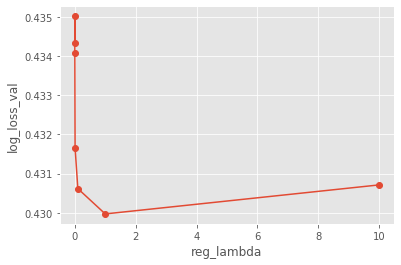

In [ ]:
# Probamos con Regularización L2
parametros['reg_lambda'] = busca_param([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10], 'reg_lambda', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


n_estimators=25 log_loss_val=0.4425404461676596
n_estimators=35 log_loss_val=0.4399343994700137
n_estimators=45 log_loss_val=0.4360084798728476
n_estimators=55 log_loss_val=0.4361511093396945
n_estimators=65 log_loss_val=0.4346733587889715
n_estimators=75 log_loss_val=0.431119537044669
n_estimators=85 log_loss_val=0.43266028683401075
n_estimators=95 log_loss_val=0.4298684512792656
n_estimators=105 log_loss_val=0.42995687094414475
n_estimators=115 log_loss_val=0.43225873356304495
n_estimators=125 log_loss_val=0.4325096503481253
n_estimators=135 log_loss_val=0.43488587280019264
n_estimators=145 log_loss_val=0.4355681732642852
n_estimators=155 log_loss_val=0.43525478805571455
n_estimators=165 log_loss_val=0.4357568790050633

Mejor n_estimators=95 Score=0.4298684512792656
{'learning_rate': 0.1, 'n_estimators': 95, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


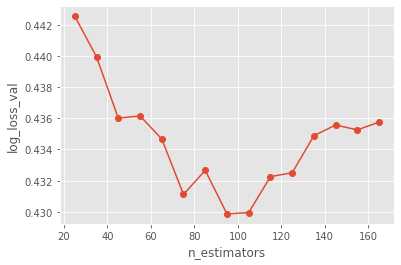

In [ ]:
parametros['n_estimators'] = busca_param(np.arange(parametros['n_estimators']-75,parametros['n_estimators']+75,10),
                                         'n_estimators', parametros)
print(parametros)

### Creamos la Submission con el Modelo Stacking

In [ ]:
X_orig = X_train_scaled.copy()
y_orig = y.copy()

In [ ]:
%%time
random_seed = 1234
stack_model = XGBClassifier(learning_rate=parametros['learning_rate'],
                                  n_estimators=parametros['n_estimators'],
                                  max_depth=parametros['max_depth'],
                                  subsample=parametros['subsample'],
                                  colsample_bytree=parametros['colsample_bytree'],
                                  reg_alpha=parametros['reg_alpha'], 
                                  reg_lambda=parametros['reg_lambda'],
                                  nthread=20, 
                                  seed=random_seed, objective='multi:softprob')
loss_stack, y_stack, preds_val_stack, preds_test_stack  = entrena_model_folds(stack_model, 
                                                                              calibra=True, 
                                                                              random_seed=random_seed)
print('STACKING MODEL=',loss_stack)

ITER= 0
ITER= 1
ITER= 2
ITER= 3
ITER= 4
STACKING MODEL= 0.43758643133826514
CPU times: user 1h 12min 11s, sys: 1min 41s, total: 1h 13min 52s
Wall time: 3min 41s


In [ ]:
output = pd.DataFrame(preds_test_stack,columns=["Class_"+str(i) for i in range(1,10)])
output.insert(loc=0, column='id', value=df_test.id)
output.to_csv('submission_stacking_5cv.csv', index=False)
pd.read_csv('submission_stacking_5cv.csv').head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.000108,0.080944,0.095124,0.817550,0.000000,0.000280,0.005731,0.000185,0.000079
1,2,0.003851,0.006229,0.001190,0.000958,0.000061,0.341329,0.002376,0.639633,0.004373
2,3,0.000000,0.000000,0.000000,0.000034,0.000000,0.999922,0.000000,0.000044,0.000000
3,4,0.000130,0.613143,0.373452,0.011276,0.000076,0.000347,0.000553,0.000378,0.000646
4,5,0.136289,0.000330,0.000257,0.000590,0.000049,0.006441,0.000934,0.098722,0.756388


El modelo stacking obtiene con 5CV un **Local=0.43758643133826514, Private_LB=0.42031, Public_LB=0.41901, que nos situaria en la posición 170 del Private Leaderboard de 3511 equipos (percentil 95.16) dándonos una MEDALLA DE PLATA**. 

**EJERCICIO 3.B.3: Incluir las predicciones del modelo LightGBM y recalcular el modelo de Stacking.**

**Crear la submission y presentar los Scores Finales Publicos y Privados. Comparar los resultados usando con y sin LGB** 

**Incluir en este script una foto de la pantalla de Kaggle con los resultados de la submission y en que posición del PRIVATE LEADERBOARD quedaria.**

**ATENCION: Para reducir los tiempos de entrenamiento del modelo stacking es recomendable reducir los rangos de búsqueda de los parámetros basándose en los mejores valores obtenidos con el anterior modelo de stacking**

In [9]:
# Cargamos la Base de Datos Previa de Stacking
if False:
    file = open('bd_stacking.pickle','wb')
    pickle.dump(df_train_stack, file, protocol=4)
    pickle.dump(df_test_stack, file, protocol=4)
    file.close()
else:
    file = open('bd_stacking.pickle','rb')
    df_train_stack = pickle.load(file)
    df_test_stack = pickle.load(file)
    file.close()

df_train_stack.head()

,RF_c1,RF_c2,RF_c3,RF_c4,RF_c5,RF_c6,RF_c7,RF_c8,RF_c9,LOGIT_c1,LOGIT_c2,LOGIT_c3,LOGIT_c4,LOGIT_c5,LOGIT_c6,LOGIT_c7,LOGIT_c8,LOGIT_c9,MLP_c1,MLP_c2,MLP_c3,MLP_c4,MLP_c5,MLP_c6,MLP_c7,MLP_c8,MLP_c9,XGB_c1,XGB_c2,XGB_c3,XGB_c4,XGB_c5,XGB_c6,XGB_c7,XGB_c8,XGB_c9,target
0,0.004751,0.000000,0.000000,0.000609,0.000024,0.991835,0.001017,0.000874,0.000891,0.000421,1.025263e-09,4.243281e-13,2.627042e-05,8.122726e-15,9.981520e-01,1.157242e-03,0.000091,1.515615e-04,0.031715,0.000227,0.000000,0.002091,0.000000,0.922184,0.017573,0.010036,0.016174,0.045687,0.000000,0.000000,0.000571,0.000000,0.947854,0.002085,0.001720,0.002084,0
1,0.160114,0.000871,0.000455,0.001055,0.001351,0.035908,0.017885,0.779444,0.002918,0.155829,8.521797e-02,2.530527e-02,7.770715e-03,1.007624e-02,8.310513e-02,6.314196e-02,0.461452,1.081016e-01,0.244329,0.023963,0.015216,0.002332,0.013851,0.041966,0.054434,0.575938,0.027971,0.075139,0.009410,0.002422,0.003268,0.000299,0.026141,0.024903,0.852626,0.005792,0
2,0.806111,0.001601,0.000392,0.000406,0.000422,0.009368,0.010009,0.006153,0.165538,0.355184,7.777332e-02,1.823750e-02,2.059238e-03,3.613955e-03,1.074821e-01,9.584091e-02,0.152352,1.874574e-01,0.664746,0.022006,0.000704,0.001457,0.001558,0.067723,0.079943,0.071899,0.089963,0.870528,0.005653,0.000966,0.000531,0.000188,0.011265,0.034664,0.013272,0.062932,0
3,0.748268,0.001260,0.001705,0.002352,0.000025,0.089672,0.087001,0.063076,0.006641,0.999969,2.827867e-30,1.746132e-29,1.061263e-36,6.026833e-57,1.133225e-12,3.944544e-18,0.000031,2.001580e-08,0.969485,0.000000,0.004024,0.000000,0.000000,0.000344,0.004628,0.018536,0.002984,0.879264,0.000391,0.001054,0.000573,0.000000,0.013810,0.066498,0.035808,0.002601,0
4,0.517095,0.001339,0.000837,0.000877,0.000094,0.020753,0.327586,0.127855,0.003564,0.244820,5.324813e-04,2.435576e-03,2.754070e-04,1.478748e-05,1.290583e-01,2.104049e-01,0.282810,1.296480e-01,0.484394,0.000962,0.001103,0.000960,0.000000,0.064690,0.202851,0.140808,0.104231,0.721986,0.000000,0.001261,0.000524,0.000278,0.015780,0.149308,0.105225,0.005637,0


In [11]:
def saca_features(modelo, calibra=True):
    loss, y_val, preds_val, preds_test  = entrena_model_folds(modelo, calibra=calibra)
    print(f'Loss con 5CV={loss}')
    return loss, y_val, preds_val, preds_test

In [10]:
loss_list = []
y_val_list = []
preds_val_list = []
preds_tst_list = []
names_col = []

In [14]:
lgb_model = LGBMClassifier(boosting_type='gbdt',objective='multiclass',random_state=42,
                                  n_jobs=-1,silent=True, importance_type='split',
                                  learning_rate=0.1, 
                                  n_estimators=700,
#lo dejo asi por desgracia, colab no tiene suficiente potencia, por lo que los estimadores no los multiplico x10 ni el learning rate lo divido /10
                                  max_depth=11, 
                                  min_child_weight=1, 
                                  min_child_samples=3, 
                                  subsample=0.6, 
                                  subsample_freq=1,
                                  colsample_bytree=0.9, 
                                  reg_alpha=0.1, 
                                  reg_lambda=0.0
                                  )
loss, y_val, preds_val, preds_test = saca_features(lgb_model, calibra=True)
loss_list.append(loss)
y_val_list.append(y_val)
preds_val_list.append(preds_val)
preds_tst_list.append(preds_test)
names_col.append('LGB')

ITER= 0
ITER= 1
ITER= 2
ITER= 3
ITER= 4
Loss con 5CV=0.45128400591678147


In [15]:
names_df = []
for namecol in names_col:
    for nclass in range(9):
        names_df.append(namecol+'_c'+str(nclass+1))
print(names_df)

['LGB_c1', 'LGB_c2', 'LGB_c3', 'LGB_c4', 'LGB_c5', 'LGB_c6', 'LGB_c7', 'LGB_c8', 'LGB_c9']


In [16]:
df_train_lgb = pd.DataFrame(np.concatenate(preds_val_list,axis=1),columns=names_df)
df_train_lgb.insert(loc=df_train_lgb.shape[1],column='target',value=y_val_list[0])
df_test_lgb = pd.DataFrame(np.concatenate(preds_tst_list,axis=1),columns=names_df)

In [17]:
df_train_lgb.to_csv('df_train_lgb.csv', index=False)
df_test_lgb.to_csv('df_test_lgb.csv', index=False)

In [18]:
df_train_stack=df_train_stack.drop(columns=['target'])
df_train_stack=pd.concat([df_train_stack,df_train_lgb],axis=1)
df_test_stack=pd.concat([df_test_stack,df_test_lgb],axis=1)
df_train_stack.head()

,RF_c1,RF_c2,RF_c3,RF_c4,RF_c5,RF_c6,RF_c7,RF_c8,RF_c9,LOGIT_c1,LOGIT_c2,LOGIT_c3,LOGIT_c4,LOGIT_c5,LOGIT_c6,LOGIT_c7,LOGIT_c8,LOGIT_c9,MLP_c1,MLP_c2,MLP_c3,MLP_c4,MLP_c5,MLP_c6,MLP_c7,MLP_c8,MLP_c9,XGB_c1,XGB_c2,XGB_c3,XGB_c4,XGB_c5,XGB_c6,XGB_c7,XGB_c8,XGB_c9,LGB_c1,LGB_c2,LGB_c3,LGB_c4,LGB_c5,LGB_c6,LGB_c7,LGB_c8,LGB_c9,target
0,0.004751,0.000000,0.000000,0.000609,0.000024,0.991835,0.001017,0.000874,0.000891,0.000421,1.025263e-09,4.243281e-13,2.627042e-05,8.122726e-15,9.981520e-01,1.157242e-03,0.000091,1.515615e-04,0.031715,0.000227,0.000000,0.002091,0.000000,0.922184,0.017573,0.010036,0.016174,0.045687,0.000000,0.000000,0.000571,0.000000,0.947854,0.002085,0.001720,0.002084,0.039231,0.000000,0.000000,0.000922,0.000000,0.954230,0.001702,0.002141,0.001775,0
1,0.160114,0.000871,0.000455,0.001055,0.001351,0.035908,0.017885,0.779444,0.002918,0.155829,8.521797e-02,2.530527e-02,7.770715e-03,1.007624e-02,8.310513e-02,6.314196e-02,0.461452,1.081016e-01,0.244329,0.023963,0.015216,0.002332,0.013851,0.041966,0.054434,0.575938,0.027971,0.075139,0.009410,0.002422,0.003268,0.000299,0.026141,0.024903,0.852626,0.005792,0.079383,0.008319,0.003734,0.003491,0.000228,0.026284,0.020065,0.847843,0.010652,0
2,0.806111,0.001601,0.000392,0.000406,0.000422,0.009368,0.010009,0.006153,0.165538,0.355184,7.777332e-02,1.823750e-02,2.059238e-03,3.613955e-03,1.074821e-01,9.584091e-02,0.152352,1.874574e-01,0.664746,0.022006,0.000704,0.001457,0.001558,0.067723,0.079943,0.071899,0.089963,0.870528,0.005653,0.000966,0.000531,0.000188,0.011265,0.034664,0.013272,0.062932,0.887447,0.007472,0.001408,0.000423,0.000622,0.010911,0.036503,0.013026,0.042187,0
3,0.748268,0.001260,0.001705,0.002352,0.000025,0.089672,0.087001,0.063076,0.006641,0.999969,2.827867e-30,1.746132e-29,1.061263e-36,6.026833e-57,1.133225e-12,3.944544e-18,0.000031,2.001580e-08,0.969485,0.000000,0.004024,0.000000,0.000000,0.000344,0.004628,0.018536,0.002984,0.879264,0.000391,0.001054,0.000573,0.000000,0.013810,0.066498,0.035808,0.002601,0.908253,0.000299,0.000219,0.000187,0.000000,0.007660,0.034962,0.045858,0.002561,0
4,0.517095,0.001339,0.000837,0.000877,0.000094,0.020753,0.327586,0.127855,0.003564,0.244820,5.324813e-04,2.435576e-03,2.754070e-04,1.478748e-05,1.290583e-01,2.104049e-01,0.282810,1.296480e-01,0.484394,0.000962,0.001103,0.000960,0.000000,0.064690,0.202851,0.140808,0.104231,0.721986,0.000000,0.001261,0.000524,0.000278,0.015780,0.149308,0.105225,0.005637,0.673809,0.000295,0.001680,0.000148,0.000358,0.014202,0.180534,0.123328,0.005645,0


In [19]:
names_df = df_test_stack.columns
scaler = StandardScaler()
X_train = df_train_stack[names_df].values.copy()
X_test = df_test_stack[names_df].values.copy()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
X = X_train_scaled
y = df_train_stack['target'].values.reshape(-1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=36, stratify=y)

print("Verificamos que la partición es estratificada")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_val)/len(y_val),3))

Verificamos que la partición es estratificada
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]


In [21]:
def entrena_model_hold_out(model, calibra=True, random_seed=1234):
    np.random.seed(random_seed)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds_val = calibrated_clf.predict_proba(X_val)
    else:
        model.fit(X_train, y_train)
        preds_val = model.predict_proba(X_val)

    # Extrae las métricas
    log_loss_val = log_loss(y_val, preds_val, eps=1e-15, normalize=True)
    return log_loss_val

In [22]:
def busca_param(valores, nombre_var, parametros, random_seed=1234, cv=5):
    scores = []
    for valor in tqdm(valores):
        parametros[nombre_var]=valor
        xgb_model = XGBClassifier(learning_rate=parametros['learning_rate'],
                                  n_estimators=parametros['n_estimators'],
                                  max_depth=parametros['max_depth'],
                                  subsample=parametros['subsample'],
                                  colsample_bytree=parametros['colsample_bytree'],
                                  reg_alpha=parametros['reg_alpha'], 
                                  reg_lambda=parametros['reg_lambda'],
                                  nthread=20, 
                                  seed=random_seed, objective='multi:softprob')
        log_loss_val = entrena_model_hold_out(xgb_model, calibra=True, random_seed=random_seed)
        print(f'{nombre_var}={valor} log_loss_val={log_loss_val}')
        scores.append(log_loss_val)
    plt.plot(valores,scores,'o-')
    plt.ylabel('log_loss_val')
    plt.xlabel(nombre_var)
    print(f'Mejor {nombre_var}={valores[np.argmin(scores)]} Score={np.min(scores)}')
    return valores[np.argmin(scores)]

In [23]:
# Parametros que vienen por defecto
parametros = {'learning_rate':0.1, 'n_estimators':100, 'max_depth':6,
              'subsample':0.80, 'colsample_bytree':0.80,
              'reg_alpha':0.0, 'reg_lambda':1.0}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


n_estimators=150 log_loss_val=0.4328991761773795
n_estimators=175 log_loss_val=0.4332463228228992

Mejor n_estimators=150 Score=0.4328991761773795
{'learning_rate': 0.1, 'n_estimators': 150, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


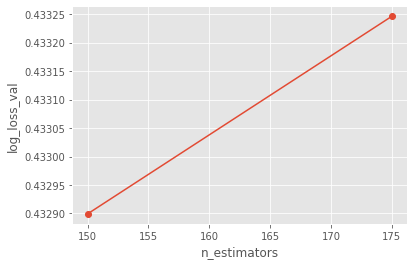

In [24]:
# Busqueda del numero de arboles
parametros['n_estimators'] = busca_param(np.arange(150,200,25), 'n_estimators', parametros)
print(parametros)

In [ ]:
parametros['max_depth'] = busca_param(np.arange(1,4), 'max_depth', parametros)
print(parametros)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
parametros['subsample'] = busca_param(np.arange(6,9)/10.0, 'subsample', parametros)
print(parametros)

In [ ]:
parametros['colsample_bytree'] = busca_param(np.arange(6,9)/10.0, 'colsample_bytree', parametros)
print(parametros)

In [ ]:
# Probamos con Regularización L1
parametros['reg_alpha'] = busca_param([0.0,0.001,0.01,0.1], 'reg_alpha', parametros)
print(parametros)

In [ ]:
# Probamos con Regularización L2
parametros['reg_lambda'] = busca_param([0.0,0.01,0.1,1.0], 'reg_lambda', parametros)
print(parametros)

In [ ]:
X_orig = X_train_scaled.copy()
y_orig = y.copy()

In [ ]:
%%time
random_seed = 1234
stack_model = XGBClassifier(learning_rate=0.01,
                                  n_estimators=175*10,
                                  max_depth=2,
                                  subsample=0.8,
                                  colsample_bytree=0.8,
                                  reg_alpha=0.0001, 
                                  reg_lambda=1.0,
                                  nthread=20, 
                                  seed=random_seed, objective='multi:softprob')
loss_stack, y_stack, preds_val_stack, preds_test_stack  = entrena_model_folds(stack_model, 
                                                                              calibra=True, 
                                                                              random_seed=random_seed)
print('STACKING MODEL=',loss_stack)

In [ ]:
output = pd.DataFrame(preds_test_stack,columns=["Class_"+str(i) for i in range(1,10)])
output.insert(loc=0, column='id', value=df_test.id)
output.to_csv('submission_parte3_david.csv', index=False)
pd.read_csv('submission_parte3_david.csv').head()

# ENTREGA

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.